# Visualize datasets
A quick intro to the dataset we collected and some state of the art related to our HANet for handover. 

||Datasets                 |amount|Object            |
|-|-------------------------|------|------------------------------------|
|1|Logistics: ConvNet [1]   |92    | 21 objects in YCB object set       |       
|2|Pose estimation: DOPE [2]|77    | products in 2017 Amazon robotic challenge  |
|3|HANet              | | |
|a|Training data      |1,060 |4 household objects and 9 object in YCB object set|
|b|Simple testing data| 200  |Same as Training data                             |
|c|Testing data       |  240 |10 objects in YCB object set, except the object in Training data|






In [1]:
# default_exp Datavisualizer

In [2]:
#hide
from nbdev.showdoc import *

## A. Create data loaders for each dataset 

In [3]:
# export 
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset
import numpy as np


class handover_grasping_dataset(Dataset):
    """Dataloader of handover datasets.
    """
    name = []
    def __init__(self, data_dir, mode='train', color_type='jpg', depth_type='npy'):
        self.image_net_mean = np.array([0.485, 0.456, 0.406])
        self.image_net_std  = np.array([0.229, 0.224, 0.225])
        self.data_dir = data_dir
        self.mode = mode
        self.color_t = color_type
        self.depth_t = depth_type
        self.transform = transforms.Compose([
                        transforms.ToTensor(),
                    ])
        if self.mode == 'train':
            f = open(self.data_dir+"/train.txt", "r")
        else:
            f = open(self.data_dir+"/test.txt", "r")
        for _, line in enumerate(f):
              self.name.append(line.replace("\n", ""))

    def __len__(self):
        return len(self.name)
    def __getitem__(self, idx):
        idx_name = self.name[idx]
        if self.color_t == 'jpg':
            color_img = cv2.imread(self.data_dir+"/color/color_"+idx_name+'.jpg')
        else:
            color_img = cv2.imread(self.data_dir+"/color/color_"+idx_name+'.png')
        color_img = color_img[:,:,[2,1,0]]
        color_img = cv2.resize(color_img,(224,224))
        color_origin = cv2.resize(color_img,(640,480))
        if self.depth_t == 'npy':
            depth_img = np.load(self.data_dir+"/depth_npy/depth_"+idx_name+'.npy')
            depth_origin = np.load(self.data_dir+"/depth_npy/depth_"+idx_name+'.npy').astype(float)
        elif self.depth_t == 'png':
            depth_img = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.png', -1)
            depth_origin = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.png', -1).astype(float)
        elif self.depth_t == 'jpg':
            depth_img = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.jpg', -1)
            depth_origin = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.jpg', -1).astype(float)
        if self.depth_t != 'npy':
            if len(depth_img.shape) == 3:
                depth_img = depth_img[:,:,0]
                depth_origin = depth_origin[:,:,0]
            
        if depth_origin.shape[0] == 224:
            depth_origin = cv2.resize(depth_origin,(640,480))
            
        depth_img = cv2.resize(depth_img,(224,224))

        if self.mode == 'train':
            label_img = np.load(self.data_dir+"/label/label_"+idx_name+'.npy')

            f = open(self.data_dir+'/idx/id_'+idx_name+'.txt', "r")

            IDX = int(f.readlines()[0])

            # Unlabeled -> 2; unsuctionable -> 0; suctionable -> 1
            label_tmp = np.round(label_img[IDX]/255.*2.).astype(float)
            label = np.zeros((4,28,28))
            # Set label pixel
            label[IDX] = cv2.resize(label_tmp, (int(28), int(28)))
            label[IDX][label[IDX] != 0.0] = 1.0

            label_tensor = self.transform(label).float()

        # uint8 -> float
        color = (color_img/255.).astype(float)
        # BGR -> RGB and normalize
        color_rgb = np.zeros(color.shape)
        for i in range(3):
            color_rgb[:, :, i] = (color[:, :, 2-i]-self.image_net_mean[i])/self.image_net_std[i]

        depth_img = np.round((depth_img/np.max(depth_img))*255).astype('int').reshape(1,depth_img.shape[0],depth_img.shape[1])
        depth = (depth_img/1000.).astype(float) # to meters
        # D435 depth range
        depth = np.clip(depth, 0.0, 1.2)
        # Duplicate channel and normalize
        depth_3c = np.zeros(color.shape)
        for i in range(3):
            depth_3c[:, :, i] = (depth[:, :]-self.image_net_mean[i])/self.image_net_std[i]


        color_tensor = self.transform(color_rgb).float()
        depth_tensor = self.transform(depth_3c).float()


        if self.mode == 'train':
            sample = {"color": color_tensor, "depth": depth_tensor, "label": label_tensor, "id": IDX, "color_origin": color_origin, "depth_origin": depth_origin}
        else:
            sample = {"color": color_tensor, "depth": depth_tensor, "color_origin": color_origin, "depth_origin": depth_origin}

        return sample
    
class rosenberger_dataloader():
    def __init__(self, data_dir, color_type='jpg', depth_type='npy'):
        self.color_t = color_type
        self.depth_t = depth_type
        self.data_path = data_dir
        yolo = open(self.data_path+'/yolo_result.txt', "r")
        self.boxes = []
        for i, line in enumerate(yolo):
            data = line.replace("\n", "")
            if i%6 != 0:
                data = float(data)
                if data > 1.0:
                    data = data
                box.append(data)
            elif i == 0:
                box = []
            else:
                self.boxes.append(box)
                box = []
        self.name_list = []
        f = open(self.data_path+'/test.txt', "r")
        for i, line in enumerate(f):
            name = line.replace("\n", "")
            self.name_list.append(name)
        self.pt = 0
        
    def length(self):
        print(len(self.name_list))
        
    def get_next_data(self, vis_bbox=False):
        if self.pt >= len(self.name_list):
            self.pt = 0
        idx = self.name_list[self.pt]
        color = cv2.imread(self.data_path+'/color/color_'+idx+'.'+self.color_t)
        
        if self.depth_t == 'npy':
            depth = np.load(self.data_path+'/depth_npy/depth_'+idx+'.npy')
            depth = depth/1000.0
        else:
            depth = cv2.imread(self.data_path+'/depth/depth_'+idx+'.png',-1)
            if len(depth.shape) == 3:
                depth = depth[:,:,0]/1000.0
            else:
                depth = depth/1000.0
            
        mask_hand = cv2.imread(self.data_path+'/mask_hand/mask_hand_'+idx+'.png', cv2.IMREAD_GRAYSCALE)
        mask_body = cv2.imread(self.data_path+'/mask_body/mask_body_'+idx+'.png', cv2.IMREAD_GRAYSCALE)
        mask_hand[mask_hand==30] = 0.0
        mask_body[mask_body==30] = 0.0
        
        depth_nan = np.isnan(depth).astype(np.uint8)
        
        best_box = self.boxes[self.pt]
        
        if vis_bbox:
            color_bbox = cv2.imread(self.data_path+'/color/color_'+idx+'.'+self.color_t)
            color_bbox = cv2.cvtColor(color_bbox, cv2.COLOR_BGR2RGB)
            box = self.boxes[self.pt]

            p_lu = (int(box[0]), int(box[1]))
            p_rd = (int(box[2]), int(box[3]))
            p_ld = (int(box[0]), int(box[3]))
            p_ru = (int(box[2]), int(box[1]))

            color_bbox = cv2.line(color_bbox,p_lu,p_ru,(0,255,0),3)
            color_bbox = cv2.line(color_bbox,p_ru,p_rd,(0,255,0),3)
            color_bbox = cv2.line(color_bbox,p_rd,p_ld,(0,255,0),3)
            color_bbox = cv2.line(color_bbox,p_ld,p_lu,(0,255,0),3)
            
            sample = {"color":color, "depth":depth, "depth_nan":depth_nan, "mask_hand":mask_hand, "mask_body":mask_body, "bbox":best_box, "color_bbox":color_bbox}
        else:
            sample = {"color":color, "depth":depth, "depth_nan":depth_nan, "mask_hand":mask_hand, "mask_body":mask_body, "bbox":best_box}
        
        self.pt += 1
        
        return sample
    
class parallel_jaw_based_grasping_dataset(Dataset):
    def __init__(self, data_dir, use_zeng=True, scale=1./8):
        self.name = []
        self.use_zeng = use_zeng
        self.image_net_mean = np.array([0.485, 0.456, 0.406])
        self.image_net_std  = np.array([0.229, 0.224, 0.225])
        self.data_dir = data_dir
        self.scale = scale
        self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])
        if self.use_zeng:
            f = open(self.data_dir+"/test-split.txt", "r")
        else:
            f = open(self.data_dir+"/test.txt", "r")
        for i, line in enumerate(f):
            self.name.append(line.replace("\n", ""))
    def __len__(self):
        return len(self.name)
    def __getitem__(self, idx):
        idx_name = self.name[idx]
        if self.use_zeng:
            color_img = cv2.imread(self.data_dir+"/heightmap-color/"+idx_name+".png")
            color_origin_img = cv2.imread(self.data_dir+"/heightmap-color/"+idx_name+".png")
            depth_img = cv2.imread(self.data_dir+"/heightmap-depth/"+idx_name+".png", -1)
            depth_origin_img = cv2.imread(self.data_dir+"/heightmap-depth/"+idx_name+".png", -1)
            label_img = cv2.imread(self.data_dir+"/label/"+idx_name+".png", cv2.IMREAD_GRAYSCALE)
        else:
            color_img = cv2.imread(self.data_dir+"/color/color_"+idx_name+'.jpg')
            color_origin_img = cv2.imread(self.data_dir+"/color/color_"+idx_name+'.jpg')
            depth_img = np.load(self.data_dir+"/depth/depth_"+idx_name+'.npy')
            depth_origin_img = np.load(self.data_dir+"/depth/depth_"+idx_name+'.npy')
            
        
        color_img = color_img[:,:,[2,1,0]]      
        color = (color_img/255.).astype(float)
        color_rgb = np.zeros(color.shape)
        

        for i in range(3):
            color_rgb[:, :, i] = (color[:, :, 2-i]-self.image_net_mean[i])/self.image_net_std[i]
        
        depth = (depth_img/1000.).astype(float) # to meters
        depth = np.clip(depth, 0.0, 1.2)
        depth_3c = np.zeros(color.shape)
        for i in range(3):
            depth_3c[:, :, i] = (depth[:, :]-self.image_net_mean[i])/self.image_net_std[i]

        
        color_tensor = self.transform(color_rgb).float()
        depth_tensor = self.transform(depth_3c).float()

        color_list = []
        depth_list = []
        
        color_origin_list = []
        depth_origin_list = []
        
        color_list.append(color_tensor)
        depth_list.append(depth_tensor)
        
        color_origin_list.append(color_origin_img.astype('int16'))
        depth_origin_list.append(depth_origin_img.astype('float32'))

        angle_list = []
        for i in range(15):
            angle_list.append((i+1)*22.5)

        center = (int(color_rgb.shape[1]/2), int(color_rgb.shape[0]/2))

        for angle in angle_list:
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            color_ = cv2.warpAffine(color_rgb, M, (color_rgb.shape[1], color_rgb.shape[0]))
            depth_ = cv2.warpAffine(depth_3c, M, (color_rgb.shape[1], color_rgb.shape[0]))
            
            color_o = cv2.warpAffine(color_origin_img, M, (color_origin_img.shape[1], color_origin_img.shape[0]))
            depth_o = cv2.warpAffine(depth_origin_img, M, (color_origin_img.shape[1], color_origin_img.shape[0]))
            
            color_ = self.transform(color_).float()
            depth_ = self.transform(depth_).float()

            color_list.append(color_)
            depth_list.append(depth_)
            
            color_origin_list.append(color_o.astype('int16'))
            depth_origin_list.append(depth_o.astype('float32'))

    
        if self.use_zeng:
            label = np.round(label_img/255.*2.).astype(float)
            label_tensor = self.transform(label).float()
            sample = {"color": color_list, "depth": depth_list, "label":label_tensor, "color_origin": color_origin_list, "depth_origin": depth_origin_list}
        else:
            sample = {"color": color_list, "depth": depth_list, "color_origin": color_origin_list, "depth_origin": depth_origin_list}
        
        return sample

## 3a. HANet Training Datasets
Data num : 1080

Image size : RGB (224x224x3) / Depth (224x24) / Label (224x224x4)

senario: An object held by 1 of 3 sitting people at the desk or a laying person at the patient bed

Source: 
1. RGB-D images taken by the camera arranged at the robot arm
2. RGB-D images synthesized by the colored point clouds from 2 cameras arranged at the robot arms respectively

### a. Load data

In [16]:
from torch.utils.data import  DataLoader
from matplotlib import pyplot as plt
import cv2
from handover_grasping.Datavisualizer import handover_grasping_dataset
# loal data
DATA_PATH = '/home/arg/handover_grasping/data/HANet_v2_datasets'

dataset = handover_grasping_dataset(DATA_PATH, color_type='png')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 8)

### b. Visualize

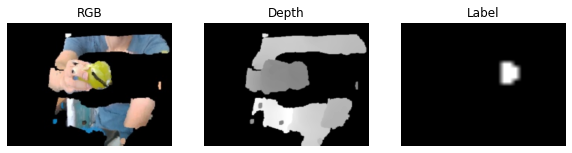

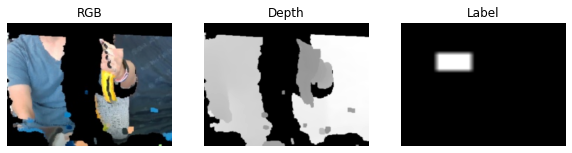

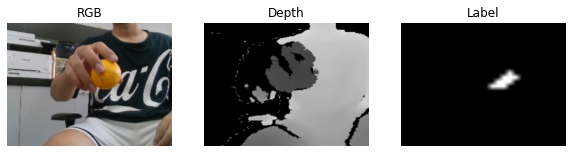

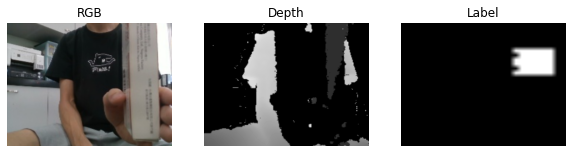

In [5]:
for _ in range(4):
    # Get smaple data
    batch = next(iter(dataloader))
    # RGB and Depth image
    color = batch['color_origin'][0].numpy()
    depth = batch['depth_origin'][0].numpy()

    # object angle id and label
    idx = batch['id'][0].numpy()
    label = batch['label'][0].permute(2,0,1).numpy()[:,:,idx]
    label = cv2.resize(label, (640,480))
    
    # Visualize
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 3, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 3, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')

    fig.add_subplot(1, 3, 3)
    plt.axis('off')
    plt.title('Label')
    plt.imshow(label, cmap='gray')

## 3b. Visualize HANet Easy Testing Datasets
### a. Load data

In [17]:
from handover_grasping.Datavisualizer import rosenberger_dataloader
hanet_easy_loader = rosenberger_dataloader('/home/arg/handover_grasping/data/HANet_easy_datasets')

### b. Visualize

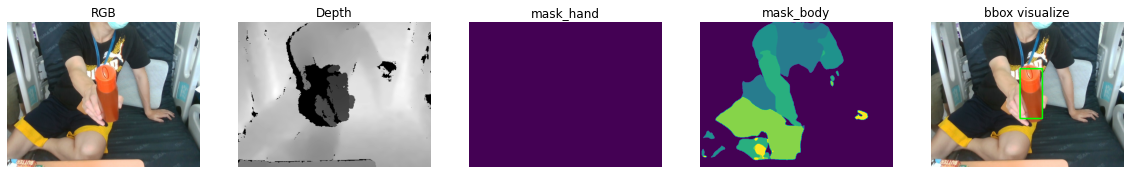

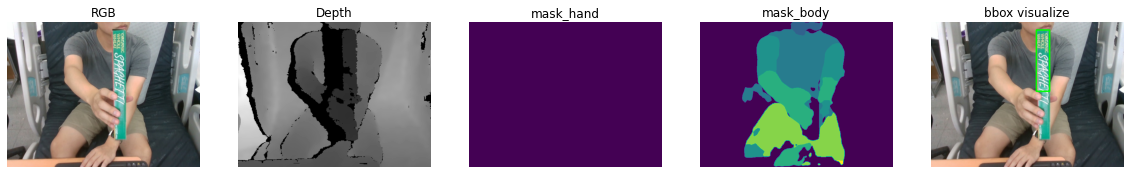

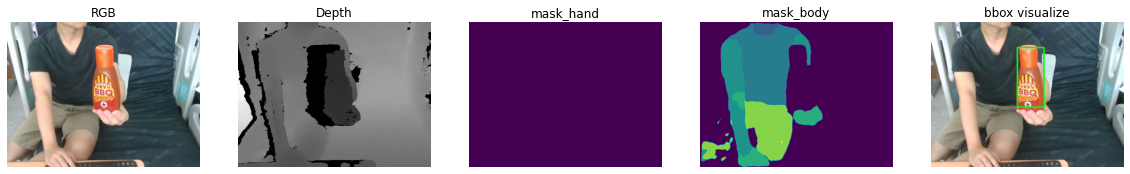

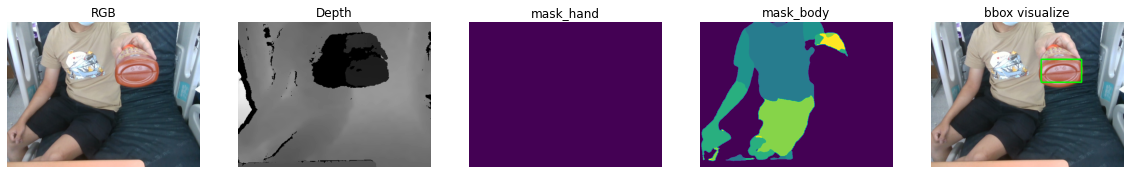

In [7]:
for _ in range(4):
    # Get sample data
    batch = hanet_easy_loader.get_next_data(vis_bbox=True)
    color = batch['color']
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    color_bbox = batch['color_bbox']
    depth = batch['depth']
    mask_hand = batch['mask_hand']
    mask_body = batch['mask_body']
    bbox = batch['bbox']
    
    # Visualize
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 5, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 5, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')

    fig.add_subplot(1, 5, 3)
    plt.axis('off')
    plt.title('mask_hand')
    plt.imshow(mask_hand)

    fig.add_subplot(1, 5, 4)
    plt.axis('off')
    plt.title('mask_body')
    plt.imshow(mask_body)

    fig.add_subplot(1, 5, 5)
    plt.axis('off')
    plt.title('bbox visualize')
    plt.imshow(color_bbox)
    
    plt.show()

## 2. Visualize parallel_jaw_based_grasping_dataset
ref:https://github.com/andyzeng/arc-robot-vision

### a. Load Data
This dataloader will load image and rotate 16 time from 0 to 337.5 degrees

In [18]:
import cv2
from torch.utils.data import  DataLoader
from matplotlib import pyplot as plt
from handover_grasping.Datavisualizer import parallel_jaw_based_grasping_dataset
from handover_grasping.utils import Image_table

dataset = parallel_jaw_based_grasping_dataset('/home/arg/handover_grasping/data/parallel-jaw-grasping-dataset', use_zeng=True)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 1)

### b. Get sample data

In [19]:
batch = next(iter(dataloader))
# RGB and Depth image list, each contain 16 images
colors = batch['color_origin']
depths = batch['depth_origin']

### c. Visualize
1. RGB

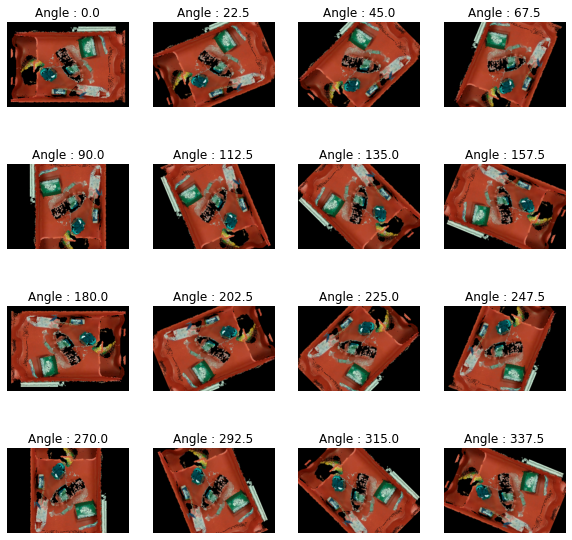

In [20]:
color_list = []
title_list = []
for i in range(len(colors)):
    color_sub = colors[i][0].numpy()
    color_list.append(color_sub[:,:,[2,1,0]])
    title_list.append('Angle : '+str(i*22.5))
    
Image_table(4, 4, color_list, title_list)

2. Depth

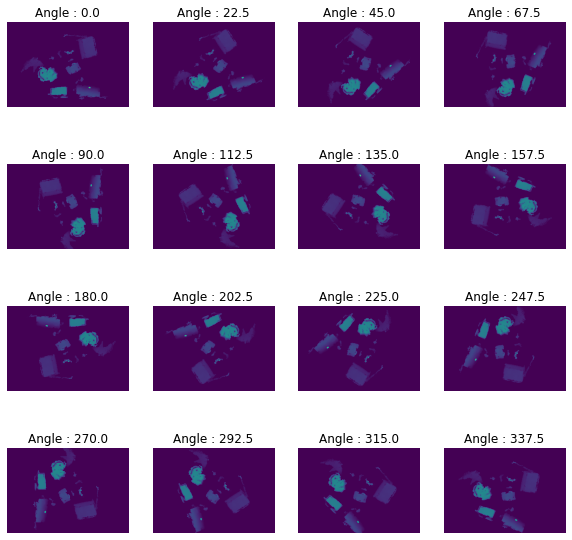

In [21]:
depth_list = []
for i in range(len(depths)):
    depth_sub = depths[i][0].numpy()
    depth_list.append(depth_sub)
    
Image_table(4, 4, depth_list, title_list)

## 1. Visualize DOPE Testing datasets
Using clip images of YCB-Video, include RGB-D images 
ref:https://github.com/yuxng/PoseCNN

### a. Load data

In [22]:
from handover_grasping.Datavisualizer import rosenberger_dataloader
import cv2
from matplotlib import pyplot as plt

hanet_easy_loader = rosenberger_dataloader('/home/arg/handover_grasping/data/Dope_testing', color_type='png',depth_type='png')

### b. Visualize

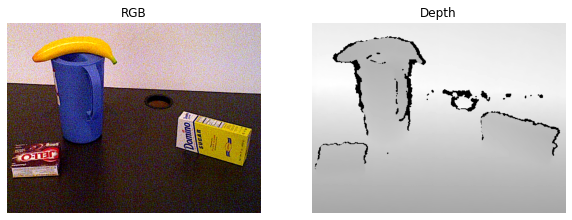

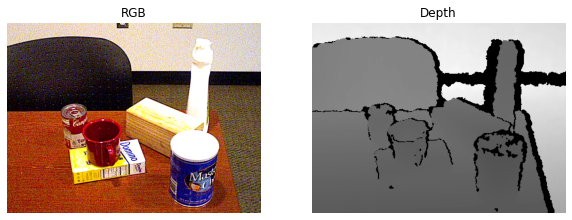

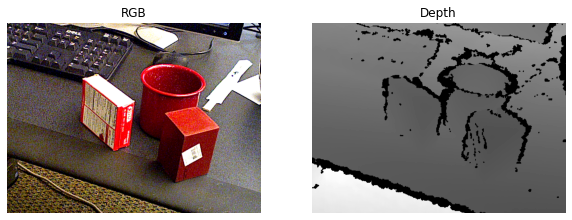

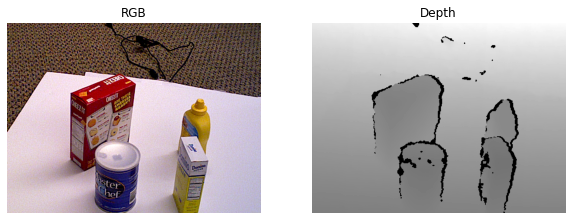

In [23]:
for _ in range(4):
    # Get sample data
    batch = hanet_easy_loader.get_next_data()
    color = batch['color']
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth = batch['depth']
    
    # Visualize
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')
    
    plt.show()